In [1]:
from IPython.display import Image
from matplotlib import pyplot as plt
from modnet.hyper_opt.fit_genetic import FitGenetic
from modnet.models import EnsembleMODNetModel
from modnet.preprocessing import MODData
from pathlib import Path
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde, spearmanr
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold

import copy
import json
import numpy as np
import os
import pandas as pd
import plotly.graph_objs as go
import uncertainty_toolbox as uct

2025-01-05 15:42:12.201045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-05 15:42:12.364925: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 15:42:12.387749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vtrinquet/local/lib:
2025-01-05 15:42:12.387772: I tensorflow/compiler/xla/stream_execut

In [2]:
# Import sys and set the path of the customized modules
import sys
sys.path.append('/home/vtrinquet/Documents/Doctorat/JNB_Scripts_Clusters/Custom_Modules/')
sys.path.append('/home/vtrinquet/Documents/Doctorat/JNB_Scripts_Clusters/NLO/HT/shg/acquisition')
sys.path.append('/home/vtrinquet/Documents/Doctorat/JNB_Scripts_Clusters/Active_Learning/PP_uncertainty_calibration_scripts')


# Import importlib.reload to be able to reload dynamically modified modules
from importlib import reload

# Import custom modules (reloadable when modified)
import unc_metrics as unccal
unccal = reload(unccal)

In [3]:
cur_v = int(Path(os.getcwd()).parent.name.split("_")[0])
print(cur_v)

19


# Benchmark

In [4]:
# Load the MODData
path_md = f'../data/mod.data_dKP_fastfeat_n_Eg_pgnn_featselec_v{cur_v}'
os.system(f"gunzip {path_md}.gz")
md = MODData.load(path_md)
os.system(f"gzip {path_md}")
print(f"{md.df_featurized.shape = }")

2025-01-05 15:42:17,027 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7b8d6dc619f0> object, created with modnet version 0.4.4
md.df_featurized.shape = (2518, 1290)


In [5]:
kf = KFold(5, shuffle=True, random_state=42)

## dKP

../models/bmk_GA_Rf0_Nstd5_5fold-dKP/GA_Rf0_Nstd5_5fold-dKP_0.pkl.gz


2025-01-05 15:42:18.761294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vtrinquet/local/lib:
2025-01-05 15:42:18.761316: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-01-05 15:42:18.761326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PC-SE22-351): /proc/driver/nvidia/version does not exist
2025-01-05 15:42:18.761726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-01-05 15:42:20,440 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7b8ce87f8a90> object, created with modnet version 0.4.4
16/16 [==============================] - 0s 1ms/step
Scaling factor MA fold 0: 1.4366322164255134
Scaling factor NLL: 24.619866738353178
../models/bmk_GA_Rf0_Nstd5_5fold-dKP/GA_Rf0_Nstd5_5fold-dKP_1.pkl.gz
2025-01-05 15:42:31,453 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7b8ce742e950> object, created with modnet version 0.4.4
16/16 [==============================] - 0s 2ms/step
Scaling factor MA fold 1: 1.2965739416891258
Scaling factor NLL: 20.056858129312502
../models/bmk_GA_Rf0_Nstd5_5fold-dKP/GA_Rf0_Nstd5_5fold-dKP_2.pkl.gz
2025-01-05 15:42:44,728 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7b8cdacc5b40> object, created with modnet version 0.4.4
16/16 [==============================] - 0s 1ms/step
Scaling factor MA fold 2: 1.3907316892759112
Scaling

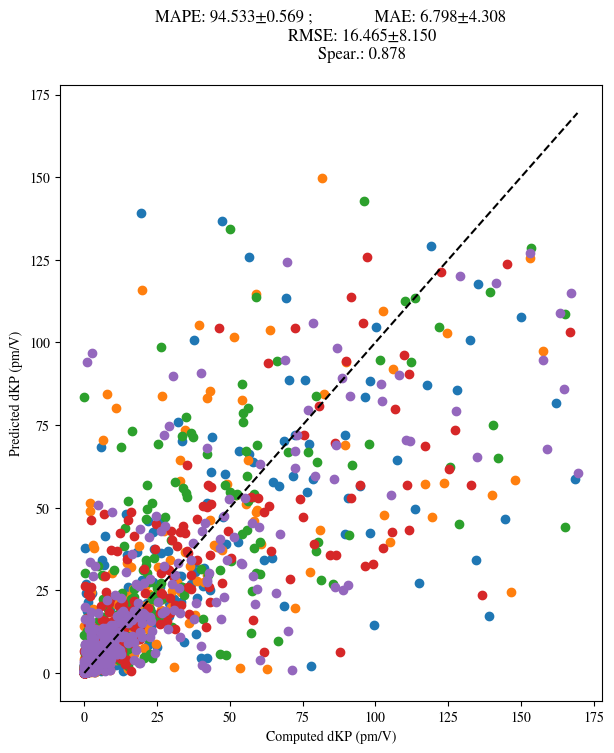

In [6]:
# error on dKP
name_target_metric = "dKP"
targets = ["dKP"]
experiment_name = "GA_Rf0_Nstd5_5fold-" + "-".join(targets)
pred_mape = []
pred_mae = []
pred_rmse = []
pred_spr = []
unc_mape = []
unc_mae = []
unc_rmse = []
df_predictions = pd.DataFrame()
list_ma_scaling = []
list_nll_scaling = []


path_fig_bmk = (Path("..") / "figures/bmk" / f"bmk_{experiment_name}_{name_target_metric}_wo_unc.png")
path_predictions = (Path("..") / "figures/bmk" / f"bmk_{experiment_name}_{name_target_metric}.pkl.gz")
path_scores = (Path("..") / "figures/bmk" / f"bmk_{experiment_name}_{name_target_metric}.json.gz")

if path_fig_bmk.exists():
    df_scores = pd.read_json(path_scores)
    df_predictions = pd.read_pickle(path_predictions)
    fig = Image(filename=path_fig_bmk)
    display(fig)
else:
    plt.figure(figsize=(7,8))
    for ind, (train, test) in enumerate(
        kf.split(md.df_featurized, y=md.df_targets)
    ):
        train_moddata, test_moddata = md.split((train, test))

        model_path = (
            Path("..") / "models" / f"bmk_{experiment_name}" / f"{experiment_name}_{ind}.pkl.gz"
        )
        print(model_path)
        if model_path.exists():
            os.system(f"gunzip {model_path}")
            model_path = str(model_path).replace(".gz", "")
            model = EnsembleMODNetModel.load(model_path)
            os.system(f"gzip {model_path}")
        else:
            raise FileNotFoundError("The models do not exist yet")
            # train_moddata.feature_selection(n=-1, n_samples=len(train_moddata)+1, n_jobs=2)
            # ga = FitGenetic(train_moddata, sample_threshold=len(train_moddata)+1)
            # model = ga.run(
            #     size_pop=20, # dflt 20
            #     num_generations=10, # dflt 10
            #     nested=5, # dflt = 5
            #     n_jobs=4,
            #     early_stopping=4, # dflt 4 
            #     refit=0, # dflt = 5
            #     fast=False,
            # )
            # model.save(model_path)
    
        predictions, uncertainties = model.predict(test_moddata, return_unc=True)
        predictions[f"{name_target_metric}_unc"] = uncertainties[name_target_metric].tolist()
        predictions["fold"] = [ind] * len(predictions)
        df_predictions = pd.concat([df_predictions, predictions], axis=0)

        pred_mape.append(mean_absolute_percentage_error(test_moddata.df_targets[name_target_metric].values.ravel(), predictions[name_target_metric].values.ravel()))
        pred_mae.append(mean_absolute_error(test_moddata.df_targets[name_target_metric].values.ravel(), predictions[name_target_metric].values.ravel()))
        pred_rmse.append(root_mean_squared_error(test_moddata.df_targets[name_target_metric].values.ravel(), predictions[name_target_metric].values.ravel()))
        pred_spr.append(spearmanr(test_moddata.df_targets[name_target_metric].values.ravel(), predictions[name_target_metric].values.ravel()).statistic)
        unc_mape.append(np.mean(uncertainties[name_target_metric]/predictions[name_target_metric]))
        unc_mae.append(mean_absolute_error([0]*len(uncertainties), uncertainties[name_target_metric].values.ravel()))
        unc_rmse.append(root_mean_squared_error([0]*len(uncertainties), uncertainties[name_target_metric].values.ravel()))

        # Uncertainty calibration via Miscalibration Area
        std_recalibrator = uct.recalibration.get_std_recalibrator(
            predictions[name_target_metric].to_numpy(), 
            predictions[f"{name_target_metric}_unc"].to_numpy(),
            test_moddata.df_targets[name_target_metric].to_numpy()
        )
        calib_ratio = std_recalibrator(1)
        print(f"Scaling factor MA fold {ind}: {calib_ratio}")
        list_ma_scaling.append(calib_ratio)

        # Uncertainty calibration via Negative log-likelihood
        scaling = np.mean(
            np.square(predictions[name_target_metric].to_numpy() - test_moddata.df_targets[name_target_metric].to_numpy()) / np.square(predictions[f"{name_target_metric}_unc"].to_numpy())
        )
        print(f"Scaling factor NLL: {scaling}")
        list_nll_scaling.append(scaling)
    
        plt.scatter(
            test_moddata.df_targets[name_target_metric].values.ravel(),
            predictions[name_target_metric].values.ravel(),
        )
    
    print("="*10 + f" {experiment_name} " + "="*10)
    print("Training complete.")
    print("Training complete.")
    print(f"Pred. MAPE: {pred_mape}")
    print(f"Unc. MAPE: {unc_mape}")
    print(f"Pred. MAE: {pred_mae}")
    print(f"Unc. MAE: {unc_mae}")
    print(f"Pred. RMSE: {pred_rmse}")
    print(f"Unc. RMSE: {unc_rmse}")
    print(f"Pred. SPR: {pred_spr}")
    
    plt.plot(
        np.linspace(
            np.min(md.df_targets[name_target_metric].values),
            np.max(md.df_targets[name_target_metric].values),
            3,
        ),
        np.linspace(
            np.min(md.df_targets[name_target_metric].values),
            np.max(md.df_targets[name_target_metric].values),
            3,
        ),
        color="black",
        ls="--",
    )
    
    plt.ylabel(f"Predicted {name_target_metric} (pm/V)")
    plt.xlabel(f"Computed {name_target_metric} (pm/V)")
    plt.title(f"MAPE: {np.mean(pred_mape):.3f}±{np.mean(unc_mape):.3f} ; \
              MAE: {np.mean(pred_mae):.3f}±{np.mean(unc_mae):.3f}\n \
              RMSE: {np.mean(pred_rmse):.3f}±{np.mean(unc_rmse):.3f}\n \
              Spear.: {np.mean(pred_spr):.3f}\n \
              ")

    plt.savefig(path_fig_bmk)
    plt.savefig(Path(str(path_fig_bmk).replace("png", "pdf")))

    df_predictions[f"{name_target_metric}_unc_cal_ma"] = df_predictions[f"{name_target_metric}_unc"]*np.mean(list_ma_scaling)
    df_predictions[f"{name_target_metric}_unc_cal_nll"] = df_predictions[f"{name_target_metric}_unc"]*np.mean(list_nll_scaling)
    df_predictions.to_pickle(path_predictions)
    df_scores = pd.DataFrame.from_dict({ 'mape': pred_mape, 'mae': pred_mae, 'rmse': pred_rmse, 'rho_sp': pred_spr,
                                         'mape_unc': unc_mape, 'mae_unc': unc_mae, 'rmse_unc': unc_rmse, 
                                         'list_ma_scaling': list_ma_scaling, 'list_nll_scaling': list_nll_scaling})
    df_scores.to_json(path_scores)


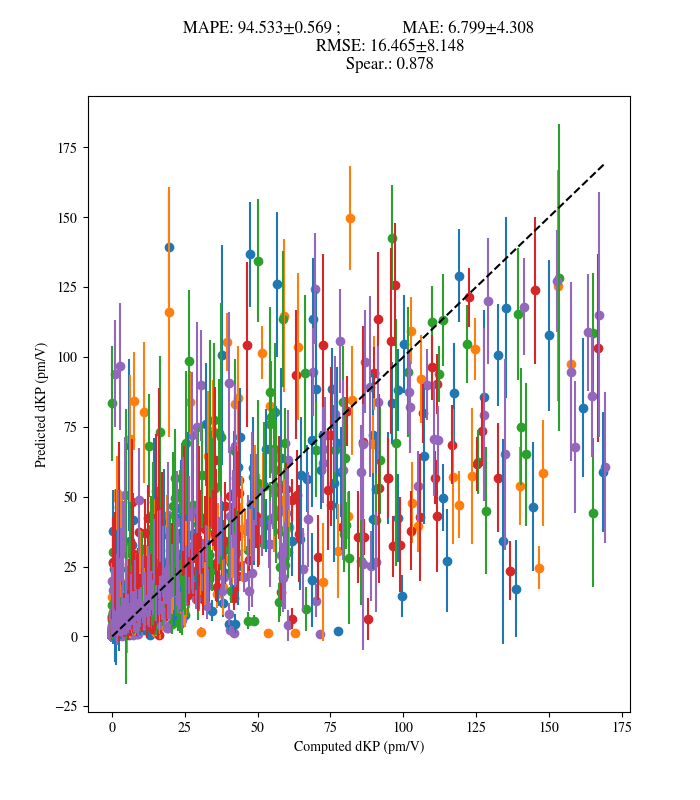

In [7]:
# error on dKP
name_target_metric = "dKP"
targets = ["dKP"]
experiment_name = "GA_Rf0_Nstd5_5fold-" + "-".join(targets)
pred_mape = []
pred_mae = []
pred_rmse = []
pred_spr = []
unc_mape = []
unc_mae = []
unc_rmse = []
df_predictions = pd.DataFrame()
list_ma_scaling = []
list_nll_scaling = []


path_fig_bmk = (Path("..") / "figures/bmk" / f"bmk_{experiment_name}_{name_target_metric}.png")
path_predictions = (Path("..") / "figures/bmk" / f"bmk_{experiment_name}_{name_target_metric}.pkl.gz")
path_scores = (Path("..") / "figures/bmk" / f"bmk_{experiment_name}_{name_target_metric}.json.gz")

if path_predictions.exists():
    df_scores = pd.read_json(path_scores)
    df_predictions = pd.read_pickle(path_predictions)
    fig = Image(filename=path_fig_bmk)
    display(fig)
else:
    plt.figure(figsize=(7,8))
    for ind, (train, test) in enumerate(
        kf.split(md.df_featurized, y=md.df_targets)
    ):
        train_moddata, test_moddata = md.split((train, test))

        model_path = (
            Path("..") / "models" / f"bmk_{experiment_name}" / f"{experiment_name}_{ind}.pkl.gz"
        )
        print(model_path)
        if model_path.exists():
            os.system(f"gunzip {model_path}")
            model_path = str(model_path).replace(".gz", "")
            model = EnsembleMODNetModel.load(model_path)
            os.system(f"gzip {model_path}")
        else:
            raise FileNotFoundError("The models do not exist yet")
            # train_moddata.feature_selection(n=-1, n_samples=len(train_moddata)+1, n_jobs=2)
            # ga = FitGenetic(train_moddata, sample_threshold=len(train_moddata)+1)
            # model = ga.run(
            #     size_pop=20, # dflt 20
            #     num_generations=10, # dflt 10
            #     nested=5, # dflt = 5
            #     n_jobs=4,
            #     early_stopping=4, # dflt 4 
            #     refit=0, # dflt = 5
            #     fast=False,
            # )
            # model.save(model_path)
    
        predictions, uncertainties = model.predict(test_moddata, return_unc=True)
        predictions[f"{name_target_metric}_unc"] = uncertainties[name_target_metric].tolist()
        predictions["fold"] = [ind] * len(predictions)
        df_predictions = pd.concat([df_predictions, predictions], axis=0)

        pred_mape.append(mean_absolute_percentage_error(test_moddata.df_targets[name_target_metric].values.ravel(), predictions[name_target_metric].values.ravel()))
        pred_mae.append(mean_absolute_error(test_moddata.df_targets[name_target_metric].values.ravel(), predictions[name_target_metric].values.ravel()))
        pred_rmse.append(root_mean_squared_error(test_moddata.df_targets[name_target_metric].values.ravel(), predictions[name_target_metric].values.ravel()))
        pred_spr.append(spearmanr(test_moddata.df_targets[name_target_metric].values.ravel(), predictions[name_target_metric].values.ravel()).statistic)
        unc_mape.append(np.mean(uncertainties[name_target_metric]/predictions[name_target_metric]))
        unc_mae.append(mean_absolute_error([0]*len(uncertainties), uncertainties[name_target_metric].values.ravel()))
        unc_rmse.append(root_mean_squared_error([0]*len(uncertainties), uncertainties[name_target_metric].values.ravel()))

        # Uncertainty calibration via Miscalibration Area
        std_recalibrator = uct.recalibration.get_std_recalibrator(
            predictions[name_target_metric].to_numpy(), 
            predictions[f"{name_target_metric}_unc"].to_numpy(),
            test_moddata.df_targets[name_target_metric].to_numpy()
        )
        calib_ratio = std_recalibrator(1)
        print(f"Scaling factor MA fold {ind}: {calib_ratio}")
        list_ma_scaling.append(calib_ratio)

        # Uncertainty calibration via Negative log-likelihood
        scaling = np.mean(
            np.square(predictions[name_target_metric].to_numpy() - test_moddata.df_targets[name_target_metric].to_numpy()) / np.square(predictions[f"{name_target_metric}_unc"].to_numpy())
        )
        print(f"Scaling factor NLL: {scaling}")
        list_nll_scaling.append(scaling)
    
        plt.scatter(
            test_moddata.df_targets[name_target_metric].values.ravel(),
            predictions[name_target_metric].values.ravel(),
        )
        plt.errorbar(
            test_moddata.df_targets[name_target_metric].values.ravel(),
            predictions[name_target_metric].values.ravel(),
            yerr=uncertainties[name_target_metric].values.ravel(),
            ls="none",
        )
    
    print("="*10 + f" {experiment_name} " + "="*10)
    print("Training complete.")
    print("Training complete.")
    print(f"Pred. MAPE: {pred_mape}")
    print(f"Unc. MAPE: {unc_mape}")
    print(f"Pred. MAE: {pred_mae}")
    print(f"Unc. MAE: {unc_mae}")
    print(f"Pred. RMSE: {pred_rmse}")
    print(f"Unc. RMSE: {unc_rmse}")
    print(f"Pred. SPR: {pred_spr}")
    
    plt.plot(
        np.linspace(
            np.min(md.df_targets[name_target_metric].values),
            np.max(md.df_targets[name_target_metric].values),
            3,
        ),
        np.linspace(
            np.min(md.df_targets[name_target_metric].values),
            np.max(md.df_targets[name_target_metric].values),
            3,
        ),
        color="black",
        ls="--",
    )
    
    plt.ylabel(f"Predicted {name_target_metric} (pm/V)")
    plt.xlabel(f"Computed {name_target_metric} (pm/V)")
    plt.title(f"MAPE: {np.mean(pred_mape):.3f}±{np.mean(unc_mape):.3f} ; \
              MAE: {np.mean(pred_mae):.3f}±{np.mean(unc_mae):.3f}\n \
              RMSE: {np.mean(pred_rmse):.3f}±{np.mean(unc_rmse):.3f}\n \
              Spear.: {np.mean(pred_spr):.3f}\n \
              ")

    plt.savefig(path_fig_bmk)
    plt.savefig(Path(str(path_fig_bmk).replace("png", "pdf")))

    df_predictions[f"{name_target_metric}_unc_cal_ma"] = df_predictions[f"{name_target_metric}_unc"]*np.mean(list_ma_scaling)
    df_predictions[f"{name_target_metric}_unc_cal_nll"] = df_predictions[f"{name_target_metric}_unc"]*np.mean(list_nll_scaling)
    df_predictions.to_pickle(path_predictions)
    df_scores = pd.DataFrame.from_dict({ 'mape': pred_mape, 'mae': pred_mae, 'rmse': pred_rmse, 'rho_sp': pred_spr,
                                         'mape_unc': unc_mape, 'mae_unc': unc_mae, 'rmse_unc': unc_rmse, 
                                         'list_ma_scaling': list_ma_scaling, 'list_nll_scaling': list_nll_scaling})
    df_scores.to_json(path_scores)


In [8]:
print(df_scores['list_ma_scaling'])
print(np.mean(df_scores['list_ma_scaling']))

0    1.436632
1    1.296574
2    1.390732
3    1.493865
4    1.664932
Name: list_ma_scaling, dtype: float64
1.45654696072


In [9]:
print(df_scores['list_nll_scaling'])
print(np.mean(df_scores['list_nll_scaling']))

0    24.619867
1    20.056858
2     4.459193
3    15.043492
4    43.603993
Name: list_nll_scaling, dtype: float64
21.556680530020003


# Uncertainty calibration

Scaling factor NLL: 83.6073937051851
Scaling factor MA: 1.566291221361155


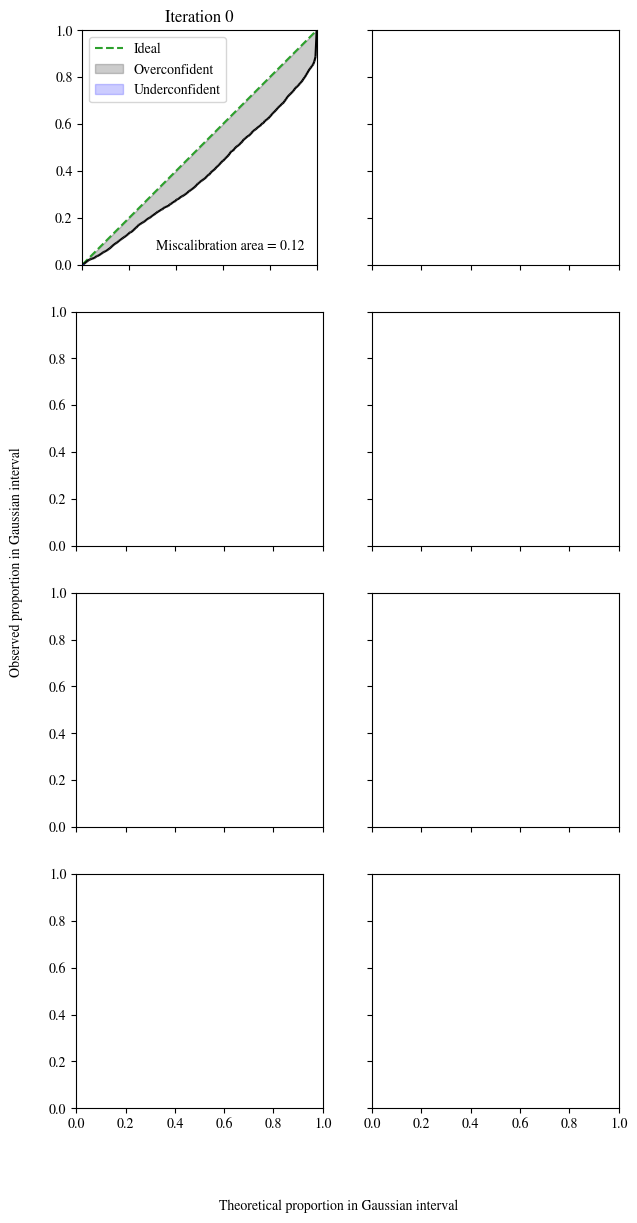

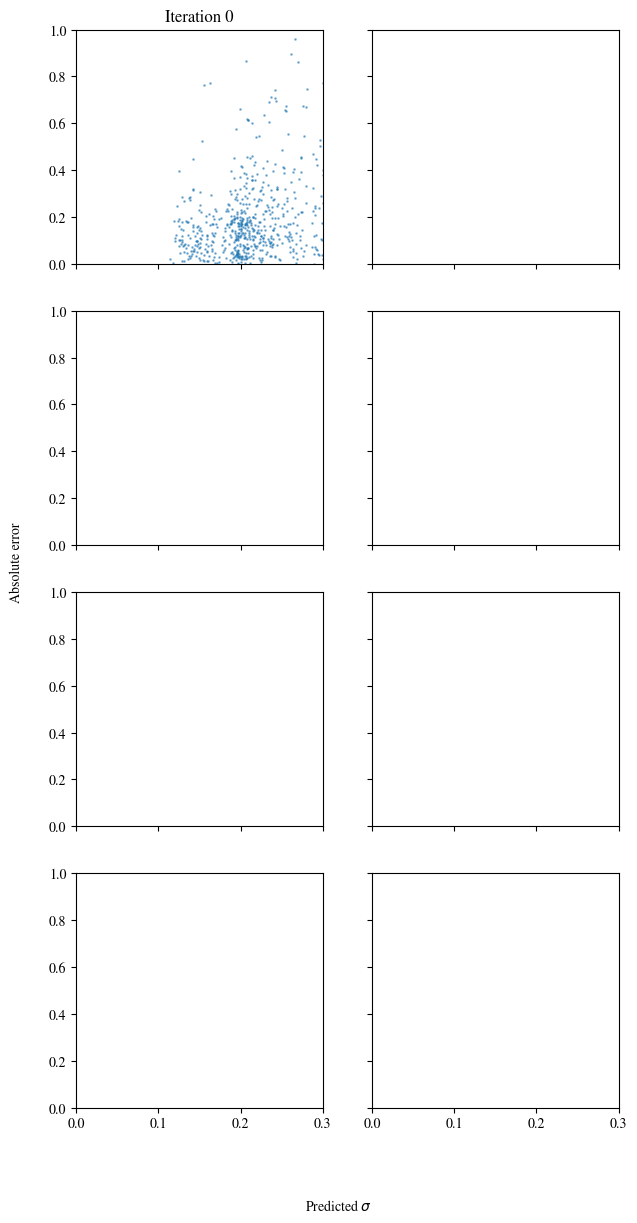

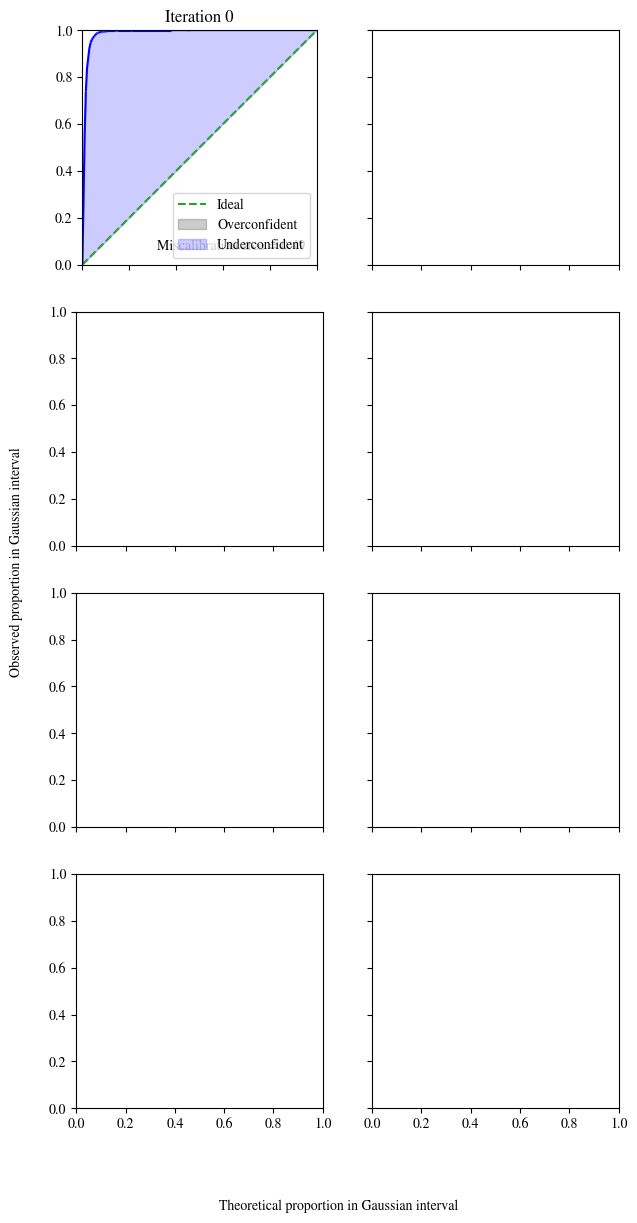

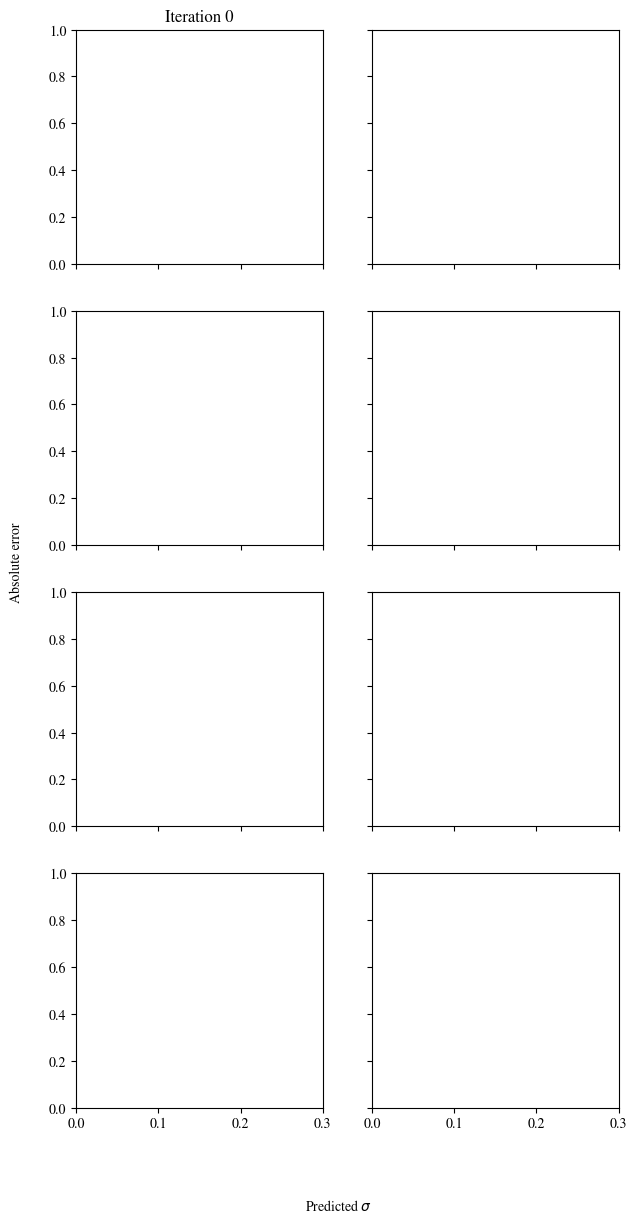

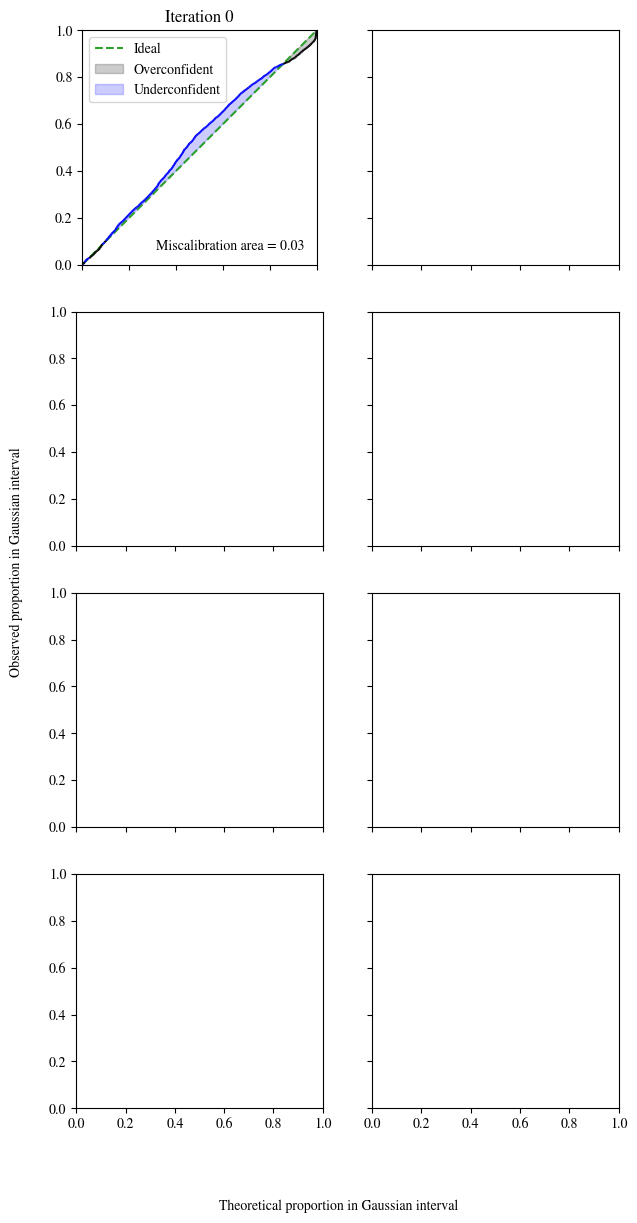

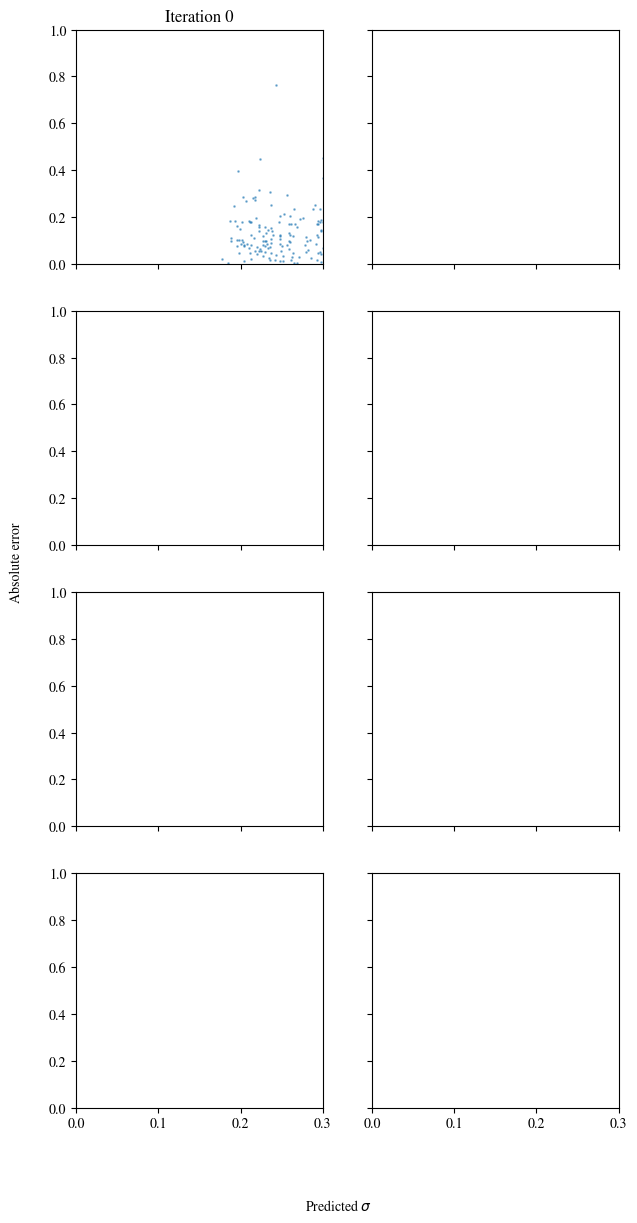

In [10]:
# Reading all files
all_true = [md.df_targets['dKP'].to_numpy()]
all_pred = [df_predictions['dKP'].filter(md.df_targets.index, axis=0).to_numpy()]
all_unc = [df_predictions['dKP_unc'].filter(md.df_targets.index, axis=0).to_numpy()]

# Computing calibration curves
unccal.run_metrics(
    all_pred,
    all_unc,
    all_true,
    title=f"original",
)

all_pred_NLL, all_unc_NLL, all_true_NLL = unccal.linear_NLL_calibration(
    all_pred,
    all_unc,
    all_true,
)

unccal.run_metrics(
    all_pred_NLL,
    all_unc_NLL,
    all_true_NLL,
    title=f"linear Gaussian NLL PHC",
)

all_pred_linear_MA, all_unc_linear_MA, all_true_linear_MA = unccal.linear_MA_calibration(
    all_pred,
    all_unc,
    all_true,
)

unccal.run_metrics(
    all_pred_linear_MA,
    all_unc_linear_MA,
    all_true_linear_MA,
    title=f"linear MA PHC",
)

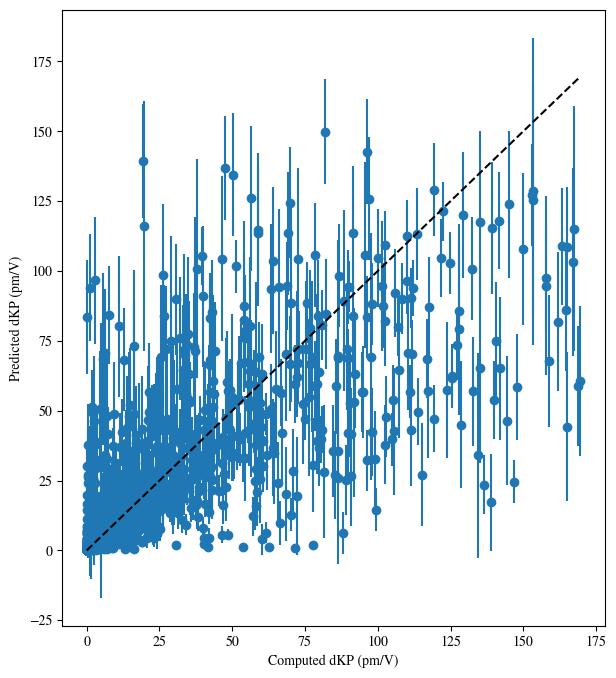

In [11]:
x = all_true[0]
y = all_pred[0]
y_err = all_unc[0]

plt.figure(figsize=(7,8))
plt.scatter(
    x,
    y,
)
plt.errorbar(
    x,
    y,
    yerr=y_err,
    ls="none",
)
plt.plot(
    np.linspace(
        np.min(x),
        np.max(x),
        3,
    ),
    np.linspace(
        np.min(x),
        np.max(x),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel(f"Predicted {name_target_metric} (pm/V)")
plt.xlabel(f"Computed {name_target_metric} (pm/V)")
plt.show()

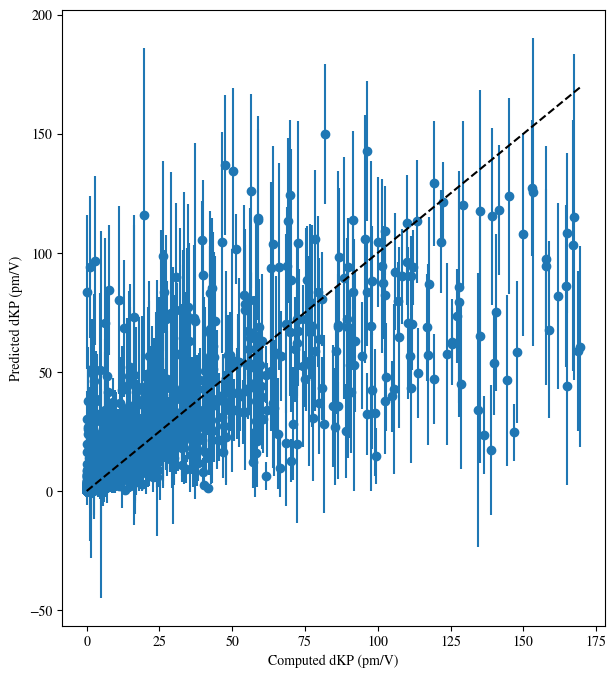

In [12]:
x = all_true_linear_MA[0]
y = all_pred_linear_MA[0]
y_err = all_unc_linear_MA[0]

plt.figure(figsize=(7,8))
plt.scatter(
    x,
    y,
)
plt.errorbar(
    x,
    y,
    yerr=y_err,
    ls="none",
)
plt.plot(
    np.linspace(
        np.min(x),
        np.max(x),
        3,
    ),
    np.linspace(
        np.min(x),
        np.max(x),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel(f"Predicted {name_target_metric} (pm/V)")
plt.xlabel(f"Computed {name_target_metric} (pm/V)")
plt.show()

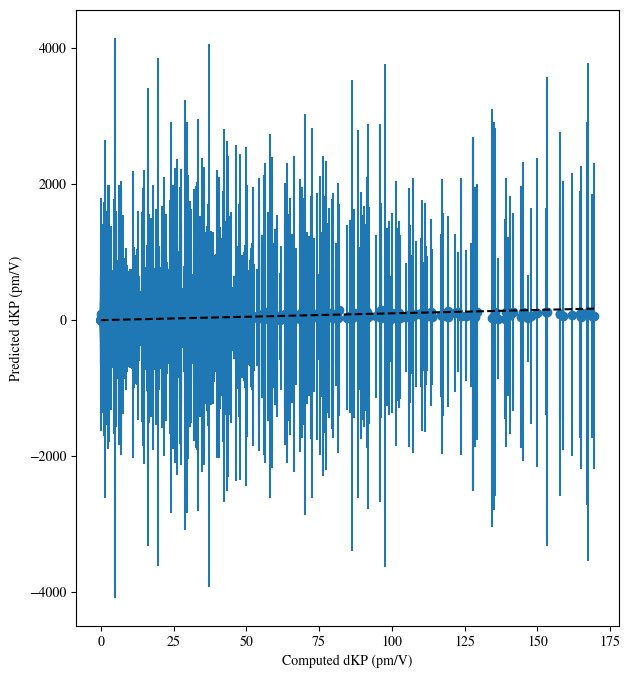

In [13]:
x = all_true_NLL[0]
y = all_pred_NLL[0]
y_err = all_unc_NLL[0]

plt.figure(figsize=(7,8))
plt.scatter(
    x,
    y,
)
plt.errorbar(
    x,
    y,
    yerr=y_err,
    ls="none",
)
plt.plot(
    np.linspace(
        np.min(x),
        np.max(x),
        3,
    ),
    np.linspace(
        np.min(x),
        np.max(x),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel(f"Predicted {name_target_metric} (pm/V)")
plt.xlabel(f"Computed {name_target_metric} (pm/V)")
plt.show()